# Periodicity Detector via the adaptive Multitaper Method (aMTM)--Python Version
## 7-11-2024
### Hector Salinas
#### Making a callable script, so I can just update the code from one place. 
* Most bullet point snippets/remarks dated before this script's creation are from other scipts where I tested/used the Python Signal Detector algorithm I made in other scripts: `Simone Di Matteo PSD aMTM Tool`, `FFT Analysis Practice`, and `Apr2024_EM Wave Analysis test`
---
* (6-29-2023)Simone's Paper describing his IDL code (Di Matteo 2021, JGR): 
    * https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020JA028748
* (7-14-2023)The imported multitaper method (MTM) python package ws designed by German Prieto
    * https://github.com/gaprieto/multitaper
    * Their website: https://gaprieto.com/software/
* **Fourier Transform Basics**: 
    * X($f_k) = \int_{0}^{T} x(t)e^{-i2\pi ft} dt$ $\rightarrow$ Discrete $\rightarrow$ X[k] = $\Sigma_{n=0}^{N-1}x[n]e^{-i2\pi(k\Delta f)(n\Delta t)}$ = $\Sigma_{n=0}^{N-1}x[n]e^{-i(2\pi k/N)n}$ 
    * where k,n are integers from 0$\rightarrow$N-1
    * X[k]: Fourier coefficients from periodic sequence x[n]
    * Frquency Axis (based on above physical defintions) of Fourier Transform, $f_k = k\Delta f$
        * Where $\Delta f (or f_{ray}) = 1/T = 1/(N\Delta t)$, is the Sampling (Rayleigh) Frequency and T is the period/window length of the time series (in seconds) 
    * $\Delta$t = time step or sample interval (time between samples)
        * Instrument sampling rate: $\Delta$s = 1/$\Delta$t 
        * N = number of datapoints in time series; also used for number of iterations for FFT summation
    * Nyquist Frequency $f_{nyq}$ = 1/($\Delta t \cdot2$)
---
### Code Updates
* (7-15-2024) Renamed "get_data" functions as: `get_atam_specs`, `get_background_psdfit()`, `get_gamtest_confs`, `get_ftest_confs`, `get_gftest_confpeaks`, `freqtrim_amtm_specs()`


In [1]:
%matplotlib inline 
#^----plot figures in command line
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec #nice alternatie way of doing subplots
#-Scipy Packages-v
from scipy import optimize 
from scipy.signal import find_peaks, find_peaks_cwt #displaying peaks on data
import scipy.stats #for Ftest confidence levels
import scipy.special as sc #normalized lower incomplete gamma function is 'sc.gammainc' and regular gamma function `sc.gamma`
#-Prieto MTM Packages-v
from multitaper import MTSpec, MTCross, MTSine, SineCross
import multitaper.utils as utils
#-All other packages-v
import numpy as np
import random
from scipy.fft import fft, ifft, irfft, rfft

## 1) Function Which Returns aMTM Spectral Data Products
* `get_amtm_specs()`**uses Prieto's MTM package and returns aMTM power spectra ($S_k$), the corresponding frequencies ($f_k$), the half-degrees of freedom ($α_k$), and the Harmonic F-test ($F_k$) over the positive frequency range [0, $f_{ny}$].** 
---
* Degrees of Freedom:
    * $\nu_j = 2\alpha_j = 2(\Sigma_0^{K-1}d_k^2(f_j))^2/(\Sigma_0^{K-1}d_k^4(f_j))$ 
        * where $d_k(f_j)$ = weights from adaptive MTM/eigenvalue for each dpss taper
* We can emulate a white noise process by doing DATA = x[n] + o[n], where o[n] is our noise array defined by a normal (Gaussian) distribution as `np.random.normal(mu, sigma, len(x[n]))`
    * standard normal distribution is a Gaussian with mu = 0 and sigma = 1


In [2]:
def get_amtm_specs(xdata, tdata, NW, Ktpr = None):
    """Using Prieto's MTM python package: Compute/return the aMTM PSD, corresponding frequencies, 
    half-degrees of freedom, and F-test arrays over the positive frequency range [0, fny]
    
    :Params:
        xdata: data series to be Fourier transformed (ie. X(t), Y(t), etc)
        tdata: corresponding "time" series of above data series
        NW: (>1, an integer) frequency resolution bandwidth
        Ktpr: (optional, int) number of tapers to use 
    :Returns:
        afFreq_pf: corresponding Fourier frequencies defined over positive frequency (pf) range
        afSk_pf: aMTM PSD estimate defined of positive frequency range
        afAlphak_pf: half-degrees of freedom defined over positive frequency range
        afFtest_pf: Harmonic F-test defined over positive frequency range
    """    
    if Ktpr is None:
        Ktpr = 2*NW-1 #default value
    else:
        Ktpr = Ktpr 
    [dt, N, fray, F_nyq] = get_tseries_params(tdata) #return dt, N, fray, fnyq
    afData_nmean = xdata-np.nanmean(xdata) #removing mean from data array
    print('Nyquist frequency = ', F_nyq, ', dt = ', dt, ', T = ', tdata[-1]-tdata[0], ', N = ', N)
    #--Extract Pietro MTM Spectra Data
    print('Creating Prieto MTSPEC class for Data(NW = %d, Ktpr = %d)'%(NW, Ktpr))
    psd_class = MTSpec(afData_nmean, NW, Ktpr, dt, nfft = N, iadapt=0)     
    afFreq ,afRaw_Sk = psd_class.rspec() #return PDS at positive frequencies (up to Nyquist Freq)
    aafWeight = psd_class.wt #extract spectra weights
    afAlpha = get_spectra_dofA(Ktpr, aafWeight, len(afFreq)) #compute alphaj from MTM Spectra half degrees-of-freedom definition
    #--Extract F test for positive freq only (up to Nyquist frequency)
    Ftest,p = psd_class.ftest()
    Ftest = Ftest[0:psd_class.nf]
    #print('afFreq type:', type(afFreq), '\nafRawSk type',type(afRaw_Sk),'\nafAlphaj type',type(afAlpha), '\nFtest type:', type(Ftest))
    #print('afFreq shape:', np.shape(afFreq), '\nafRawSk shape',np.shape(afRaw_Sk),'\nafAlphaj shape',np.shape(afAlpha), '\nFtest shape:', np.shape(Ftest))
    """Prieto casts most of the spectra dataproducts as a 1D array inside an array making them 2D. 
    So we enforce them to be 1D arrays to avoid errors. """ 
    return (afFreq[:,0], afRaw_Sk[:,0], afAlpha, Ftest[:,0]);
    

def get_spectra_dofA(Ktprs, weight, nyqLen):
    """Define alpha_j from half degrees of freedom formula in Simone+, JGR 2021 
    
    :Params:
        Ktprs: (int) number of tapers
        weight: (mxndarray) MTM spectral weights
        nyqLen: (npts) lenght of frequency array up to Nyquist Frequency
    
    :Returns:
        alphaj: (ndarray) half-degrees of freedom defined over positive frequency range 
    """
    #Number of 'weights' = Number of Ktprs
    #print('We have %d weights'%Ktprs)
    #print(np.shape(weight))
    #Initialize fSum variables
    #'''
    w2_sum = 0
    w4_sum = 0
    for i in range(Ktprs):
        w2_sum = w2_sum + weight[:nyqLen, i]**2
        w4_sum = w4_sum + weight[:nyqLen, i]**4
    '''
    #Works for NW = 3, K = 5 --v
    d1 = weight[:nyqLen,0]
    d2 = weight[:nyqLen,1]
    d3 = weight[:nyqLen,2]
    d4 = weight[:nyqLen,3]
    d5 = weight[:nyqLen,4]
    w2_sum = d1**2 + d2**2 + d3**2 + d4**2 + d5**2
    w4_sum = d1**4 + d2**4 + d3**4 + d4**4 + d5**4
    #''';
    alphaj = (w2_sum**2)/w4_sum
    #print('\tShape of alphaj array:', np.shape(alphaj))
    #fig, ax = plt.subplots(5, figsize = (12,10))
    #ax[0].plot(weight[:,0])
    #plt.plot(alphaj)
    return(alphaj);

def get_tseries_params(tdata):
    """Return time series parameters: dt, N, fny, fray
    :Params:
        tdata: correpsonding time array of datas series
    """
    dt = tdata[1] - tdata[0] #time step / sampling interval
    N = len(tdata) #length of time array
    df = 1/(N*dt) #Sample (Rayleigh) Frequency
    F_nyq = 1/(2*dt) # Nyquist Frequency
    return(dt, N, df, F_nyq);

Rayleigh frequency is 0.2 and N =  2500
Nyquist frequency =  250.0 , dt =  0.002 , T =  4.998 , N =  2500
Creating Prieto MTSPEC class for Data(NW = 3, Ktpr = 5)


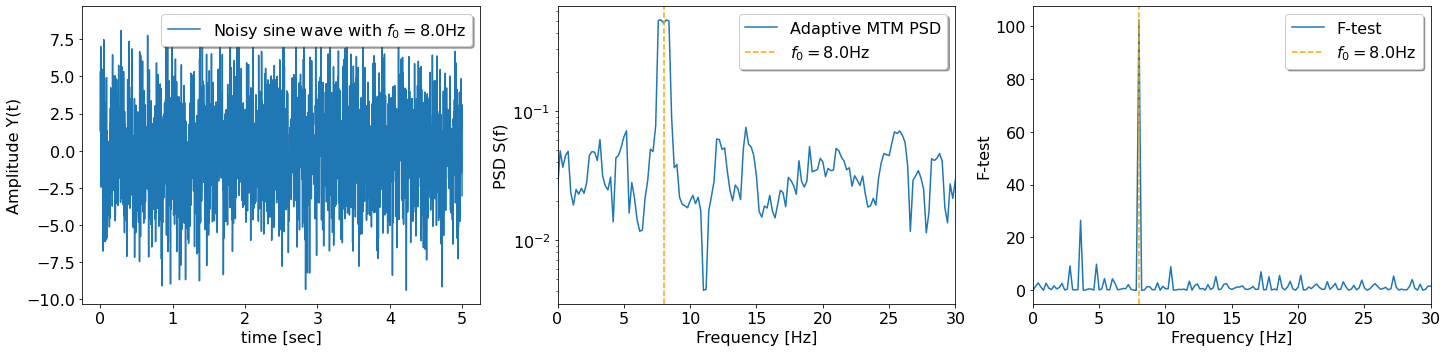

In [3]:
#--------------Testing FUNCTION 1--------------------#
#----Defining anonymous functions (Python's version of explicit math functions)
fSine = lambda A,f,t: A*np.sin(2*np.pi*f*t)

def test_get_pietro():
    """Test get_pietro_spec_params"""
     #-OG Data params-
    ds = 500 #sampling rate, equivalent to dt = 0.002s
    dt = 1/ds
    afT = np.arange(0, 5, dt) #5 second interval with 1000 dtps (N = T*ds or T = N*dt)
    N = len(afT)
    f_ray = 1/(N*dt)
    f_nyq = 1/(2*dt)
    print('Rayleigh frequency is', f_ray, 'and N = ', N)
    #-Defining various time series
    freq1 = 8.0
    OG_sine = fSine(1,freq1,afT) #pure sine wave with f = 5Hz (cycles/sec)
    np.random.seed(0) #define seed so we get consistent random values
    mu, sigma = 0, 3 # standard normal distribution (Gaussian with mu = 0 and sigma = 1)
    afWhite = np.random.normal(mu, sigma, len(afT)) #making white noise based on normal (Gaussian) distribution
    afINDATA = OG_sine + afWhite
    nw_in = 3 #Ktpr = 5
    [afFreq_mtm, afSk_mtm, afAlpha_mtm, Ftest_mtm] = get_amtm_specs(afINDATA, afT, nw_in) #extract Pietro aMTM PSD and dpss
    #print(np.shape(afFreq_mtm), np.shape(afSk_mtm), np.shape(afAlpha_mtm), np.shape(Ftest_mtm))
    #--Plotting stuff
    #-Using GridSpec to plot the various time series and corresponding FFTs
    fig = plt.figure(figsize = (20,5))
    gs = GridSpec(1, 3, figure=fig) # (Row x Col) plot
    ax1 = fig.add_subplot(gs[0, 0]) 
    ax2 = fig.add_subplot(gs[0, 1]) 
    ax3 = fig.add_subplot(gs[0, 2]) 
    fsize = 16 #fontsize of axis labels/ticks
    legsize = 18 #legend fontsize
    tsize = 12 #titlesize    
        #-Plotting Time Series
    ax1.plot(afT, afINDATA, label = r'Noisy sine wave with $f_0 = %0.1f$Hz'%(freq1))
    ax1.legend(loc = 'upper right', shadow = True, prop={'size': legsize-2})
    ax1.set_ylabel('Amplitude Y(t)', fontsize = fsize)
    ax1.set_xlabel('time [sec]', fontsize = fsize)
        #-Plotting PSD
    ax2.semilogy(afFreq_mtm, afSk_mtm, label = 'Adaptive MTM PSD')
    ax2.axvline(freq1, color = 'orange', ls = '--', label = r'$f_0 = %0.1f$Hz'%(freq1))
    ax2.set_ylabel('PSD S(f)', fontsize = fsize)
    ax2.set_xlabel('Frequency [Hz]', fontsize = fsize)
    ax2.set_xlim(0, 30)
        #-Plotting Ftest
    ax3.plot(afFreq_mtm, Ftest_mtm, label = 'F-test')
    ax3.axvline(freq1, color = 'orange', ls = '--', label = r'$f_0 = %0.1f$Hz'%(freq1))
    ax3.set_xlabel(r'Frequency [Hz]', fontsize = fsize)
    ax3.set_ylabel('F-test', fontsize = fsize)
    ax3.set_xlim(0, 30)
    ax1.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
    ax2.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
    ax3.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
        #-Setting tick axes labelsize
    ax1.tick_params(axis='both', labelsize=fsize)
    ax2.tick_params(axis='both', labelsize=fsize) 
    ax3.tick_params(axis='both', labelsize=fsize) 
    plt.tight_layout()
    
    return;

#def plot_spec_ftest(inData, Sk_in, Ftest_in):
#    """Create plot of aMTM PSD and Ftest"""
    

test_get_pietro()

#help(gamma)

## 2) Function Which Returns the Background-Modelled aMTM PSD
* `get_background_psdfit()`:**With the above spectral data products ($S_k, \alpha_k, f_k$), we model the background PSD by using the 'maximum likelihood method' to apply either an analytical white noise (WHT), power law (PL), or bending power law (BPL) fit over a user-chosen frequency range**
---
* (7-24-2023) The adaptive multitaper psd does not have a gaussian distribution (has a gamma distribution as indicated in Simone+, JGR 2021), so we can't use the typical scipy optmize fit since the least squares method assumes a gaussian distribution. So instead, we have to implement a minimization algortihm to fit the power law
* **Max Log Likelihood for Adaptive MTM Spectra:**
    * M = $2\Sigma_j [\alpha_jS_j/B_j + ln[\Gamma(\alpha_j)S_j] - \alpha_jln(\alpha_jS_j/B_j)]$
    * Nice explainatino on log-likelihood functinos: https://jkillingsworth.com/2018/10/11/least-squares-and-normal-distributions/
* **Power Law (PL)** for PSD Background: B(f) = $B_j = cf_j^{-\beta}$
* **White Noise (WHT)** is PL with $\beta$ = 0: B(f) = scalar constant c
    * Has analytical solution where $c = \Sigma_k\alpha_k S_k/(\Sigma_k\alpha_k)$
* **Bending Power Law (BPL)** for PSD Background:
    * B(f) = $B_j = cf_j^{-\beta}/(1 + (f_j/f_b)^{\gamma - \beta})$ 
        * 4 parameters: constant factor "c", "$\beta$" and "$\gamma$" are the spectal indices which respectively dominate the frequency intervals above and below the frequency break "$f_b$" at which the model bends
    * From Simone+, JGR 2021: "default parameter space intervals for the BPL model are − 5 < β < 10, 0 < γ < 15, and 0 < fb < fNy, but they can be modified by the user."
    * **Correction-condition to retain BPL form when β > γ > 0:**
        * $c_{new} = cf_b^{\gamma-\beta}, \beta_{new} = \gamma, \gamma_{new} = \beta, and f_{b,new} = f_b$
* Pan Spectrum Formula (near identical to BPL with a = 1 and with "1" included in the denominator)
    * $J(E) = A x E^{-\beta_1}[1 + (E/E_0)^a]^{(\beta_1 - \beta_2)/a}$ 
    * May test in the future as Simone has only had little time to play with
* (8-7-2023) Simone Tips for Spectra Background Fitting:
    * Just as Simone did, to avoid 'divide by zero error' due to Fj[0] = 0 Hz, start at F[1:] for
    background estimates
    * "I went through my code to double check exactly what I did for the evaluation of the c-factor.
        * Always exclude the first element of the frequency vector (that is zero).  When the frequency vector includes the Nyquist frequency as well (depending on the number of points are even or odd), exclude the last element of the frequency vector (the Nyquist frequency). This is because both the spectrum values at the zero and Nyquist frequency do not follow the chi-square distribution.
    * (7-11-2024) as done in a recent update to Simone's IDL code, if there is no specified frequency interval, the background estimator will default to fitting the PSD over the [2NW f_ray, F_ny - 2NW f_ray] frequency range
* (11-29-2023) Forgot to mention back in August:
    * Python uses scipy's `optimize.minimize()` function, while IDL's `constrained min` function uses 'Generalized Reduced Gradient(GRG)' and there's no official analog in python. But here's a Github Code someone wrote: https://github.com/ishank011/grgdescent
    * Alternative GEKKO package optimizer examples: https://github.com/BYU-PRISM/GEKKO/blob/master/examples/Optimization_Introduction.ipynb

In [4]:
def get_background_psdfit(tdata,afFreq, afSpec, afAlpha, achFit, NW, Frange=None):
    """Using aMTM spectrum inputs, use the maximum log-likelihood approach to fit the noisy spectra 
    background with a Bending Power Law (BPL), Power Law (PL), or analytical White (WHT) Noise solution
    
    :Params:
        tdata: (ndarray) corresponding time array for data series
        afFreq: (ndarray) positive fourier frequency array
        afSpec: (ndarray) aMTM PSD array
        afAlpha: (ndarray) half-degrees of freedom
        achFit: (str) 'WHT', 'BPL', or 'PL' background fit option
        NW: (>1, int) frequency resolution bandwidth
        Frange: (optional, ndarray) frequency range [flow, fhigh] to perform background fit over
    
    :Returns:
        Fj_in: (ndarray) corresponding Fourier frequency array for background-fitted PSD
        Bj_best: (ndarray) background-fitted PSD
        fit_best: (ndarray) coefficients for optimal background-model coefficients
    """
    [dt, N, df, F_nyq] = get_tseries_params(tdata) #return dt, N, fray, fnyq
    #-Define Fj, Sj, and alphaj inputs that exclude frequncy bounds(0Hz, and Fnyq)
    if Frange == None: #default frequency range [2NW*fray, fny-2NW*fray]
        f_low = np.argwhere(afFreq >= 2*NW*df)
        f_up = np.argwhere(afFreq >= (F_nyq-2*NW*df))
        print('\tDefault Fitting Frequency Range: %0.1f to %0.1f Hz'%(afFreq[f_low[0,0]], afFreq[f_up[0,0]]))
        Fj_in = afFreq[f_low[0,0]:f_up[0,0]]
        alphaj_in = afAlpha[f_low[0,0]:f_up[0,0]]
        Sj_in = afSpec[f_low[0,0]:f_up[0,0]]
        achFreqRange = 'over (default) frequency range: [%0.2f, %0.2f] Hz'%(afFreq[f_low[0,0]], afFreq[f_up[0,0]]) 
    else: #user-chosen frequency rage
        print('\tFitting over frequency range', Frange,'Hz')
        f_low = np.argwhere(afFreq >= Frange[0])
        f_up = np.argwhere(afFreq >= Frange[1])
        #print(f_low[0,0],'-->',afFreq[f_low[0,0]], '\n', f_up[0,0], '-->', afFreq[f_up[0,0]])
        print('\tor %0.1f to %0.1f Hz'%(afFreq[f_low[0,0]], afFreq[f_up[0,0]]))
        Fj_in = afFreq[f_low[0,0]:f_up[0,0]]
        alphaj_in = afAlpha[f_low[0,0]:f_up[0,0]]
        Sj_in = afSpec[f_low[0,0]:f_up[0,0]]
        achFreqRange = 'over (user-chosen) frequency range: [%0.2f, %0.2f] Hz'%(afFreq[f_low[0,0]], afFreq[f_up[0,0]]) 
    '''Since the MTM Spectra and Corresponding Log-Likelihood Function both have a gamma distrbution, we
    must omit the 1st (0Hz) and last element (Nyq F) of the frequency array because both the spectrum 
    values at the zero and Nyquist frequency do not follow the chi-square distribution.'''
    # Fit Background Based on User Input
    if achFit == 'BPL':
    #Define Initial Guestimates and Optimize BPL coefficients
        print('\tBPL Fitting %s'%achFreqRange)
        bpl_guess = get_bpl_guess(Fj_in, Sj_in, alphaj_in)
        #--Defining BPL coefficient bounds
        c_bnd = (0,np.max(afSpec))
        bet_bnd = (-5,10)
        gam_bnd = (0,15)
        fb_bnd = (Fj_in[0], Fj_in[-1])
        bpl_bnds = (c_bnd, bet_bnd, gam_bnd, fb_bnd)
        achMeth = 'Powell'#'Powell'#'SLSQP'
        """ L-BFGS-B method fails and Powell works[better c-estimate that SLSQP]"""
        print('\tUsing %s optimize method--v'%(achMeth))
        bpl_min = optimize.minimize(bpl_loglikeM_ctoo, x0 = bpl_guess, args=(Fj_in, Sj_in, alphaj_in), 
                                    method = achMeth,bounds = bpl_bnds)#, options = {'disp': True})
        #bpl_min = optimize.direct(bpl_loglikeM, args=(Fj_in, Sj_in, alphaj_in),bounds = bpl_bnds)#, options = {'disp': True})
        bpl_return = bpl_min.x
        [bpl_best, bCorrect] = correct_bpl_param(bpl_return) #BPL correction check for beta > gamma
        #print(bCorrect, bpl_best)
        if bCorrect == True: # beta > gamma, we did need to do a BPL-correction
            print('\tOptimized Corrected-BPL Params for [c, beta, gamma, fb]:\n\t\t', bpl_best)
        else:
            print('\tOptimized BPL Params for [c, beta, gamma, fb]:\n\t\t', bpl_best)
        Bj_best = get_bpl_line(Fj_in, bpl_best) 
        fit_best = bpl_best
    elif achFit == 'PL':
    #Define Initial Guestimates and Optimize PL coefficients
        print('\tPower Law Fitting %s'%achFreqRange)
        bet0 = get_pl_guess(Fj_in, Sj_in, alphaj_in)
        #--Defining Power Law coefficient bounds
        c_bnd = (0,np.max(afSpec))
        bet_bnd = (0,10)
        pl_bnds = (c_bnd, bet_bnd)#[(bet_bnd)]
        achMeth = 'Powell'#'Nelder-Mead'#'Powell'#'SLSQP'
        #it appears after properly extacting the beta0 as a float fixed the Powell Method (optimize beta and c)
        """ L-BFGS-B and fails (Powell[better] and SLSQP work)"""
        print('\tUsing %s optimize method--v\n'%(achMeth))
        pl_min = optimize.minimize(pl_loglikeM, x0 = bet0, args=(Fj_in, Sj_in, alphaj_in), bounds = pl_bnds, 
                                    method = achMeth)#, bounds = pl_bnds, options = {'disp': True})
        #print(pl_min)
        pl_best = pl_min.x
        print('\tOptimized PL Params for [c, beta]:', pl_best)#([c0, bpl_guess0]
        Bj_best = get_pl_line(Fj_in, pl_best)#[c_best, pl_best]) 
        fit_best = pl_best
    else: #(default) do White Noise (PL with beta = 0) fit
        print('\tWHT Fitting (Analytical Solution) %s'%achFreqRange)
        #achMeth = 'Powell'#'Powell'#'SLSQP'
        wht_best = np.sum(alphaj_in*Sj_in)/np.sum(alphaj_in)
        print('\tAnalytical WHT Param for [c]:\t', wht_best)
        Bj_best = np.ones(len(Fj_in))*wht_best#get_bpl_line(Fj_in, bpl_best) 
        fit_best = wht_best
    return (Fj_in, Bj_best, fit_best);


#-----PL-Related Functions-v
def get_pl_line(x, c_s):
    """Eqn for Power Law, where c_s = [c, beta]
    
    :Params:
        x: (ndarray) xaxis data (ie. Frequency array)
        c_s: (ndarray) inputted coefficients [c,beta]
    
    :Returns:
        (ndarray) data series for power law
    """
    c = c_s[0]
    bet = c_s[1]
    return (c*x**(-bet));

def get_pl_cfactor(bet, afFj, afSj, alphaj):
    """Recover PL constant c-factor
    
      :Params:
        beta: (float) PL beta coefficient
        afFj: (ndarray) data series for Fourier frequencies
        afSj: (ndarray) data series for aMTM PSD
        alphaj: (ndarray) data series for half-degrees of freedom
    :Returns:
        cVal: (float) PL c-factor
    """
    cNum = alphaj*afSj*(afFj**bet)
    cVal = np.sum(cNum)/np.sum(alphaj)
    return cVal;

def get_pl_guess(afFj, afSj, alphaj):
    """Define inital guestimates for the PL parameter coefficients [c, beta]
    
    :Params:
        afFj: (ndarray) data series for Fourier frequencies
        afSj: (ndarray) data series for aMTM PSD
        alphaj: (ndarray) data series for half-degrees of freedom
    
    :Returns:
        pl_guess0: (ndarray) initial guess for PL coefficients [c, beta]
    """
    #Take guesses of initial PL fit where mid ~ (j_up - j_lw)/2; Recall np.log is log-base(e)
    #Assume j_lw and j_up correspond to 1st and last indices of the frequency array
    dUp = len(afFj)-1
    dLow = 0 
    bet0 = ( np.log10(afSj[dLow]/afSj[dUp]) ) / ( np.log10(afFj[dUp]/afFj[dLow]) ) #returns single-element array
    c0 = get_pl_cfactor(bet0, afFj, afSj, alphaj) #recover PL c-factor
    #print(type(c0), type(bet0))
    pl_guess0 = [c0, bet0]
    #print('\tInitial PL Guess for [c0, beta0]:\n\t\t', pl_guess0)
    return (pl_guess0);

def pl_loglikeM(pl_params, afFj, afSj, alphaj):
    """Function(Max log-likelihood) whose coefficient parameters(which belong to the PL Eqn) will be 
    minimized. Inputs: [c, beta], Fj, Sj, alphaj
    
     :Params:
        pl_params: (ndarray) PL coefficients [c, beta]
        afFj: (ndarray) data series for Fourier frequencies
        afSj: (ndarray) data series for aMTM PSD
        alphaj: (ndarray) data series for half-degrees of freedom
    
    :Returns:
        (float) estimate for log-likelihood function 
    """
    #print('PL params:', pl_params)
    afBj = get_pl_line(afFj, pl_params) 
    # MTM Log-Likelihood (using natural log)
    M1 = np.sum(alphaj*afSj/afBj + np.log(sc.gamma(alphaj)*afSj))
    M2 = np.sum(-alphaj*np.log(alphaj*afSj/afBj))
    #print('M1 = ', M1, 'M2 = ', M2)
    return 2*(M1 + M2);
#-----PL-Related Functions-^

#-----BPL-Related Functions-v
def get_bpl_line(x, c_s):
    """Eqn for Bending Power Law, where c_s = [c, beta, gamma, fb]
    
    :Params:
        x: (ndarray) xaxis data (ie. Frequency array)
        c_s: (ndarray) inputted coefficients [c,beta, gamma, fb]
    
    :Returns:
        (ndarray) data series for bending power law
    """
    c = c_s[0]
    bet = c_s[1]
    gam = c_s[2]
    fb = c_s[3]
    return (c*x**(-bet))/ (1 + ((x/fb)**(gam-bet)));

def get_bpl_cfactor2(bpl_guess, afFj, afSj, alphaj):
    """Recover constant c-factor using the [beta, gamma, fb] BPL coefficients and spectra data
    
      :Params:
        bpl_guess: (float) initial guess for [bet, gam, fb] BPL coefficients
        afFj: (ndarray) data series for Fourier frequencies
        afSj: (ndarray) data series for aMTM PSD
        alphaj: (ndarray) data series for half-degrees of freedom
    :Returns:
        cVal: (float) BPL c-factor
    """
    bet = bpl_guess[0]
    gam = bpl_guess[1]
    fb = bpl_guess[2]
    cNum = alphaj*afSj*(afFj**bet)*( 1 + (afFj/fb)**(gam-bet)) 
    cval = np.sum(cNum)/np.sum(alphaj)
    return cval;

def get_bpl_guess(afFj, afSj, alphaj):
    """Define inital guestimates for the BPL parameter coefficients [c, beta, gamma, fb]
    
       :Params:
        afFj: (ndarray) data series for Fourier frequencies
        afSj: (ndarray) data series for aMTM PSD
        alphaj: (ndarray) data series for half-degrees of freedom
    :Returns:
        bpl_guess1: (ndarray) initial guess for BPL coefficients [c, beta, gamma, fb]
    """
    #Take guesses of initial BPL fit where mid ~ (j_up - j_lw)/2; Recall np.log is log-base(e)
    #Assume j_lw and j_up correspond to 1st and last indices of the frequency array
    dMid = int(len(afFj)/2) #find middle index of frequency array
    dUp = len(afFj)-1
    dLow = 0 
    #Define initial guesses for [c, beta, gamma, fb]
    fb0 = afFj[dMid]
    bet0 = ( np.log(afSj[dLow]/afSj[dMid]) ) / ( np.log(fb0/afFj[dLow]) ) 
    gam0 = ( np.log(afSj[dMid]/afSj[dUp]) ) / ( np.log(afFj[dUp]/fb0))
    #print(type(bet0), type(gam0), type(fb0)) #, they're all numpy arrays
    bpl_guess0 = [bet0, gam0, fb0]
    c0 = get_bpl_cfactor2(bpl_guess0, afFj, afSj, alphaj) #recover BPL f-factor
    bpl_guess1 = [c0, bet0, gam0, fb0]
        #np.insert(bpl_guess0, 0, c0) #insert c0 as 1st element of bpl_guess array
    np.set_printoptions(suppress=True) #prevent numpy exponential printing
    #print('\tInitial BPL Guess for [c0, beta0, gamma0, fb0]:\n\t\t', bpl_guess1)#([c0, bpl_guess0]
    return (bpl_guess1);

def bpl_loglikeM_ctoo(bpl_params, afFj, afSj, alphaj):
    """Function(Max log-likelihood) whose coefficient parameters(which belong to the BPL Eqn) will be 
    minimized. Inputs: [c, beta, gamma, fb], Fj, Sj, alphaj
    
    :Params:
        bpl_params: (ndarray) BPL coefficients [c, beta, gamma, fb]
        afFj: (ndarray) data series for Fourier frequencies
        afSj: (ndarray) data series for aMTM PSD
        alphaj: (ndarray) data series for half-degrees of freedom
    
    :Returns:
        (float) estimate for log-likelihood function 
    """
    #print('\nbpl_param:', bpl_params)
    afBj = get_bpl_line(afFj, bpl_params) 
    #MTM Log-Likelihood (using natural log)
    M1 = np.sum(alphaj*afSj/afBj + np.log(sc.gamma(alphaj)*afSj))
    M2 = np.sum(-alphaj*np.log(alphaj*afSj/afBj))
    #print(type(M1))
    #print('M1 = ', M1, 'M2 = ', M2)
    return 2*(M1 + M2);

def correct_bpl_param(bpl_params):
    """Correct best-fitted BPL params for the bet > gam condition: 
    c' = c*fb^(gam-bet), bet' = gam, gam' = bet, and fb' = fb

    :Params:
        bpl_params: (ndarray) optimized BPL coefficients [c, beta, gamma, fb]
    
    :Returns:
        bpl_correct: (ndarray) corrected optimized BPL coefficients [c, beta, gamma, fb]
        bCorrect: (boolean) boolean result for if BPL correction was needed
    """
    c = bpl_params[0]
    bet = bpl_params[1]
    gam = bpl_params[2]
    fb = bpl_params[3]
    if bet > gam: #need to alter coefficients to retain BPL line
        cnew = c*fb**(gam-bet)
        bnew = gam
        gnew = bet
        bpl_correct = [cnew, bnew, gnew, fb]
        bCorrect = True
    else:
        bpl_correct = bpl_params
        bCorrect = False
    return(bpl_correct, bCorrect);
#-----BPL-Related Functions-^

Rayleigh frequency is 0.2 and N =  2500
Nyquist frequency =  250.0 , dt =  0.002 , T =  4.998 , N =  2500
Creating Prieto MTSPEC class for Data(NW = 3, Ktpr = 5)
	Default Fitting Frequency Range: 1.2 to 248.8 Hz
	BPL Fitting over (default) frequency range: [1.20, 248.80] Hz
	Using Powell optimize method--v
	Optimized BPL Params for [c, beta, gamma, fb]:
		 [  0.08514127   0.04520783   0.15429109 185.99550648]


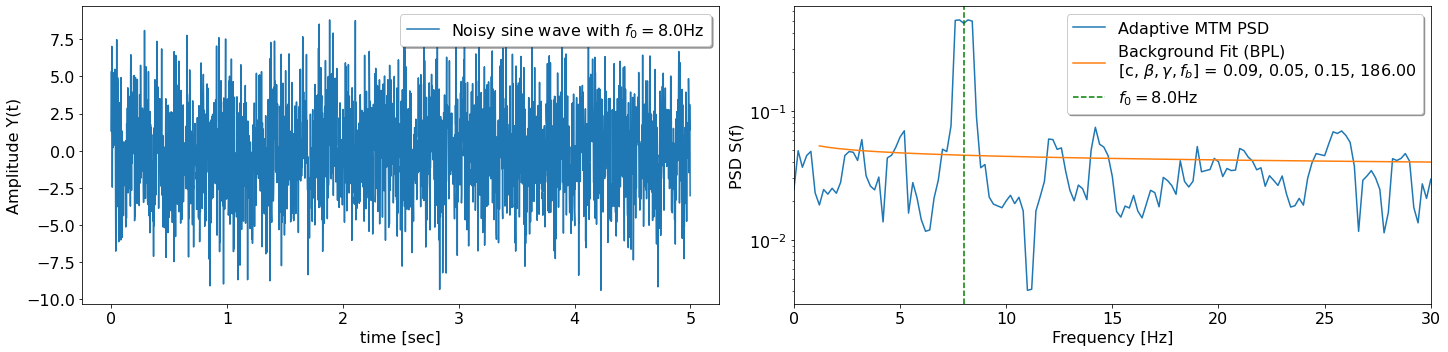

In [5]:
#-----------------------Testing FUNCTION 2------------------
def get_amtm_spec_bkgfit(xdata, tdata, achFit, NW, Ktpr=None, Frange = None):
    """Return aMTM PSD and Background-Modeled PSD Fit over user-chosen frequency range"""
    #extract Pietro aMTM PSD, alphak, Ftest arrays over positive frequency [0, fny] range
    [afFreq_mtm, afSk_mtm, afAlpha_mtm, Ftest_mtm] = get_pietro_spec_params(xdata, tdata, NW)
    [dt, N, df, F_nyq] = get_tseries_params(tdata) #return dt, N, fray, fnyq
    #Get MTM spectral dataproducts over user-define background fit frequency range
    [afFj, afAlphaj, afSj, afFtestj] = trim_specs_freqrange(tdata, afFreq, afSpec, afAlpha, afFtest, Frange=None)
    return;

def freqtrim_amtm_specs(tdata, afFreq, afSpec, afAlpha, afFtest, NW, Frange=None):
    """Define spectral dataproducts(Sk, fk, alphak, Ftest_k) over default or user-defined frequency range for
    background fitting and dual confidence periodic signal detection
    
    :Params:
        tdata: (ndarray) corresponding time array for data series
        afFreq: (ndarray) original aMTM produced data series for Fourier frequencies
        afSpec: (ndarray) original aMTM produced data series for aMTM PSD
        afAlpha: (ndarray) original aMTM produced data series for half-degrees of freedom
        afFtest: (ndarray) original aMTM produced data series for Harmonic F-test
        NW: (>1, int) frequency resolution bandwidth
        Frange: (optional, ndarray) frequency range [flow, fhigh] to perform background fit over
        
    :Returns:
        Fj_trim: (ndarray) frequency trimmed data series for Fourier frequencies
        Sj_trim: (ndarray) frequency trimmed data series for aMTM PSD
        alphaj_trim: (ndarray) frequency trimmed data series for half-degrees of freedom
        Ftest_trim: (ndarray) frequency trimmed data series for Harmonic F-test    """
    [dt, N, df, F_nyq] = get_tseries_params(tdata) #return dt, N, fray, fnyq
    if Frange == None: #default frequency range [2NW*fray, fny-2NW*fray]
        f_low = np.argwhere(afFreq >= 2*NW*df)
        f_up = np.argwhere(afFreq >= (F_nyq-2*NW*df))
        #print('\tDefault Fitting Frequency Range: %0.1f to %0.1f Hz'%(afFreq[f_low[0,0]], afFreq[f_up[0,0]]))
        Fj_trim = afFreq[f_low[0,0]:f_up[0,0]]
        alphaj_trim = afAlpha[f_low[0,0]:f_up[0,0]]
        Sj_trim = afSpec[f_low[0,0]:f_up[0,0]]
        Ftest_trim = afFtest[f_low[0,0]:f_up[0,0]]
        #achFreqRange = 'over (default) frequency range: [%0.2f, %0.2f] Hz'%(afFreq[f_low[0,0]], afFreq[f_up[0,0]]) 
    else: #user-chosen frequency rage
        #print('\tFitting over frequency range', Frange,'Hz')
        f_low = np.argwhere(afFreq >= Frange[0])
        f_up = np.argwhere(afFreq >= Frange[1])
        #print(f_low[0,0],'-->',afFreq[f_low[0,0]], '\n', f_up[0,0], '-->', afFreq[f_up[0,0]])
        #print('\tor %0.1f to %0.1f Hz'%(afFreq[f_low[0,0]], afFreq[f_up[0,0]]))
        Fj_trim = afFreq[f_low[0,0]:f_up[0,0]]
        alphaj_trim = afAlpha[f_low[0,0]:f_up[0,0]]
        Sj_trim = afSpec[f_low[0,0]:f_up[0,0]]
        Ftest_trim = afFtest[f_low[0,0]:f_up[0,0]]
    return(Fj_trim, Sj_trim, alphaj_trim, Ftest_trim);

def freqtrim_ftest(afTime_in, afFreq, afFtest, NW, Frange = None):
    """Define Ftest over user-defined background fit frequency range
    
    :Params:
        afFreq: (ndarray) original aMTM produced data series for Fourier frequencies
        afFtest: (ndarray) original aMTM produced data series for Harmonic F-test
        NW: (>1, int) frequency resolution bandwidth
        Frange: (optional, ndarray) frequency range [flow, fhigh] to perform background fit over
        
    :Returns:
        Ftest_trim: (ndarray) frequency trimmed data series for Harmonic F-test 
    """
    [dt, N, df, F_nyq] = get_tseries_params(afTime_in) #return dt, N, fray, fnyq
    if Frange == None: #default frequency range [2NW*fray, fny-2NW*fray]
        f_low = np.argwhere(afFreq >= 2*NW*df)
        f_up = np.argwhere(afFreq >= (F_nyq-2*NW*df))
        Ftest_in = afFtest[f_low[0,0]:f_up[0,0]]
    else: #user-chosen frequency rage
        f_low = np.argwhere(afFreq >= Frange[0])
        f_up = np.argwhere(afFreq >= Frange[1])
        Ftest_trim = afFtest[f_low[0,0]:f_up[0,0]]
    return(Ftest_in);
  
def test_background_fit_():
    """Test get_pietro_spec_params and fit_spectra_background"""
     #-OG Data params-
    ds = 500 #sampling rate, equivalent to dt = 0.002s
    dt = 1/ds
    afT = np.arange(0, 5, dt) #5 second interval with 1000 dtps (N = T*ds or T = N*dt)
    N = len(afT)
    f_ray = 1/(N*dt)
    f_nyq = 1/(2*dt)
    print('Rayleigh frequency is', f_ray, 'and N = ', N)
    #-Defining various time series
    freq1 = 8.0
    OG_sine = fSine(1,freq1,afT) #pure sine wave with f = 5Hz (cycles/sec)
    np.random.seed(0) #define seed so we get consistent random values
    mu, sigma = 0, 3 # standard normal distribution (Gaussian with mu = 0 and sigma = 1)
    afWhite = np.random.normal(mu, sigma, len(afT)) #making white noise based on normal (Gaussian) distribution
    afINDATA = OG_sine + afWhite
    nw_in = 3 #Ktpr = 5
    [afFreq_mtm, afSk_mtm, afAlpha_mtm, Ftest_mtm] = get_amtm_specs(afINDATA, afT, nw_in) #extract Pietro aMTM PSD and dpss
    #Extract Spectra Background Fit
    achFIT = 'BPL'
    frange_in = None#[2,10]
    [afFk_bkg, afBk, FITparams] = get_background_psdfit(afT, afFreq_mtm, afSk_mtm, afAlpha_mtm, achFIT,nw_in, frange_in) 
    #(NW,tdata,afFreq, afSpec, afAlpha, achFit, Frange=None
    if achFIT == 'BPL':
        achPSDfit = r'[c, $\beta, \gamma, f_b$] = %0.2f, %0.2f, %0.2f, %0.2f'%(FITparams[0], FITparams[1], FITparams[2], FITparams[3])
    elif achFIT == 'PL':
        achPSDfit = r'[c, $\beta$] = %0.2f, %0.2e'%(FITparams[0], FITparams[1])
    else: #default WHT solution
        achPSDfit = '[c] = %0.2f'%(FITparams)
    #print(np.shape(afFreq_mtm), np.shape(afSk_mtm), np.shape(afAlpha_mtm), np.shape(Ftest_mtm))
    #--Plotting stuff
    #-Using GridSpec to plot the various time series and corresponding FFTs
    fig = plt.figure(figsize = (20,5))
    gs = GridSpec(1, 2, figure=fig) # (Row x Col) plot
    ax1 = fig.add_subplot(gs[0, 0]) 
    ax2 = fig.add_subplot(gs[0, 1]) 
    fsize = 16 #fontsize of axis labels/ticks
    legsize = 18 #legend fontsize
    tsize = 12 #titlesize    
        #-Plotting Time Series
    ax1.plot(afT, afINDATA, label = r'Noisy sine wave with $f_0 = %0.1f$Hz'%(freq1))
    ax1.legend(loc = 'upper right', shadow = True, prop={'size': legsize-2})
    ax1.set_ylabel('Amplitude Y(t)', fontsize = fsize)
    ax1.set_xlabel('time [sec]', fontsize = fsize)
        #-Plotting PSD with background fit
    ax2.semilogy(afFreq_mtm, afSk_mtm, label = 'Adaptive MTM PSD')
    ax2.semilogy(afFk_bkg, afBk, label = 'Background Fit (%s)\n%s'%(achFIT, achPSDfit))
    ax2.axvline(freq1, color = 'green', ls = '--', label = r'$f_0 = %0.1f$Hz'%(freq1))
    ax2.set_ylabel('PSD S(f)', fontsize = fsize)
    ax2.set_xlabel('Frequency [Hz]', fontsize = fsize)
    ax2.set_xlim(0, 30)
    ax1.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
    ax2.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
        #-Setting tick axes labelsize
    ax1.tick_params(axis='both', labelsize=fsize)
    ax2.tick_params(axis='both', labelsize=fsize) 
    plt.tight_layout()
    return;

test_background_fit_()

# 3) Function which calculates confidence thresholds of $\gamma$-test and F-test to determine if a PSD enhancement is a discrete periodic signal
* `get_gamtest_confs` and `get_ftest_confs`:**After first ensuring that our spectral products ($S_k,f_k,α_k,F_k$) matches the frequency-range of our background modelled PSD ($B_k$). We compute of the confidence levels (90%, 95%, 99%) of both the $\gamma$-test ($\gamma_k = S_k/B_k$) and Harmonic F-test to explicitly determine if spectral peak(s) are statistically significant (passes both dual-confidence levels)**
---
* Defining confidence levels for both the MTM spectra and F Test
    * F_test is easy and merely defines it as the cutoff of a F-distribution: `f_conf = f_cvf(1-pp, 2, 2K-1)`(IDL format)
        * Python function for F-distribition critical value: https://stackoverflow.com/questions/39813470/f-test-with-python-finding-the-critical-value
    * $\gamma$-test is a bit more involved as it involves finding the root of the function g(z) = $C_k(z) - \epsilon$, where $C_k(z) = \int_{0}^{K}(inc\Gamma(\alpha,z\cdot\alpha))p(\alpha)d\alpha$ or $C_K[z_j] = \Sigma_{0}^{K}(inc\Gamma(\alpha_i, z\cdot\alpha_i)p[\alpha_i]\Delta\alpha$
        * **Here** $\epsilon$, or pp, is our user-defined confidence level
        * z is defined on interval [0,55] for K < 20
        * $\Gamma(x)$ is defined only for x > 0, thus inc$\Gamma(a = 0, x) = undefined$ and inc$\Gamma(a > 0, x = 0) = 0$
    * **Normalized Lower Incomplete Gamma Function**: https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gammainc.html
* (8-14-2023)
    * Defining probability density function from `plt.hist()` function: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
        * Set `Density = True` and it'll return a probability density instead of 'nCounts' such that the area under the histogram integrates to 1 (np.sum(density * np.diff(bins)) == 1)
    * Plotting cdf from `plt.hist`: https://matplotlib.org/stable/gallery/statistics/histogram_cumulative.html
    * PLotting histogram, pdf, and ecdf using Seaborn: https://seaborn.pydata.org/generated/seaborn.displot.html
* (8-17-2023):
    * Copmuting fitting parameters, pdf, cdf, and percentiles of a gamma distribution: https://saturncloud.io/blog/fitting-a-gamma-distribution-with-python-scipy-a-guide-for-data-scientists/
    * Scatter Plot log-scale: https://stackoverflow.com/questions/18773662/scatter-plot-logarithmic-scale
* (11-27-2023) Convert array of floats into a string: https://stackoverflow.com/questions/5365520/numpy-converting-array-from-float-to-strings
    * Use `.join` to convert tuple of string elements into a single string variable: https://www.w3schools.com/python/ref_string_join.asp
* (11-29-2023) Forgot to mention back in August:
    * IDL's `constrained min` function uses 'Generalized Reduced Gradient(GRG)' and there's no official analog in python. But here's a Github Code someone wrote: https://github.com/ishank011/grgdescent
    * Alternative GEKKO package optimizer examples: https://github.com/BYU-PRISM/GEKKO/blob/master/examples/Optimization_Introduction.ipynb
* (6-4-2024) Prieto's MTM package computes the adaptive spectra weights with a 1000-iteration loop and convergence limit with rerr = 9.5e-7 (based on Prieto's own Fortran F90 code). Iterates to find the optimal spectrum where oerr < rerr. And oerr = relative_error(S_amt, Sbar[avg of individual K-PSD estimates]). --"The adaptive weighted spectrum is an multi-loop iterative process that evaluates the "weights" needed to compute the adaptive PSD values. ($\Sigma wt^2 = 1$--> should be unity) This process continues until the adaptive PSD values passes a convergence limit.For Prieto's MTM package, adaptive spectra has successfully converged if the relative error is less than 9.5e-7. This is different from Di Matteo's IDL procedure that has its convergence limit when the relative error...." 
    * Under Simone's spd_mtm_adapt.pro IDL file, he set his spectral weight iteration tolerance level to 3e-4. "A value from Mann and Lees (1996) fortran code."-Simone code comment 
* (July 2nd & 11th of 2024):
    * **As indicated by Simone, he's made a modification/update as to how he computes the CDF of the gamma-statistic.** 
        * palpha = hist(binsze = 0.1, bins = (min_pal-2*binsze, Ktpr+2*bnsz)
            * minpal = floor(min(alpha)*10)/10 #we only need nonzero portion of alpha (pdf gives 0-vals)
            * maxpal gives extra bin for trapzoid integration and accounts for oscillations of alpha
        * z is defined on [0,15) interval (dz = 0.001) and covers most of CDF range for K<20
        * For each C[z] integral evaluation, Simone does a trapezoid integration. Python has scipy trapezoid or cumtrapz intgration. I can just modify the the double for loop that for each z-value iteration, it does scipy.trapezoid where the palpha array has no 0-vals in it for how we defined the pdf
            * https://stackoverflow.com/questions/71301970/is-there-a-method-for-finding-the-root-of-a-function-represented-as-an-narray
            * https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.cumulative_trapezoid.html
    * for the CDF calculation, the Python version does an explicit summation (integration alternate) while the IDL version does a "trapezoid integration"
    * Also default frequency range to background fit over: [2NW f_ray, F_ny - 2NW f_ray] as indicated in recent simone update

In [8]:
def get_gamtest_confs(tdata, afFreq, afSpec, afAlpha, afBkg, NW, Frange = None):
    """Compute/return the (90,95,99)% confidence levels of the gamma-test(aMTM PSD/Background Fit) 
    using the spectral dataproducts (fk, Sk, Bk, alphak) (NEW way of Compute/Return Confidence Level for the aMTM PSD)
    
     :Params:
        tdata: (ndarray) corresponding time array for data series
        afFreq: (ndarray) positive fourier frequency array
        afSpec: (ndarray) aMTM PSD array
        afAlpha: (ndarray) half-degrees of freedom
        afBkg: (nedarray) Background-fitted PSD
        NW: (>1, int) frequency resolution bandwidth
        Frange: (optional, ndarray) frequency range [flow, fhigh] to perform background fit over
    
    :Returns:
        gammaj: (ndarray) gamma-test array 
        afZ[ind90[0,0]]: (float) 90% confidence level gamma-test value 
        afZ[ind95[0,0]]: (float) 95% confidence level gamma-test value 
        afZ[ind99[0,0]]: (float) 99% confidence level gamma-test value 
        afZ[ind50[0,0]]: (float) 50% confidence level gamma-test value
    """
    #Ensuring spectral products match background fit frequency range
    [dt, N, df, F_nyq] = get_tseries_params(tdata) #return dt, N, fray, fnyq
    if Frange == None: #default frequency range [2NW*fray, fny-2NW*fray]
        f_low = np.argwhere(afFreq >= 2*NW*df)
        f_up = np.argwhere(afFreq >= (F_nyq-2*NW*df))
        Fj_in = afFreq[f_low[0,0]:f_up[0,0]]
        alphaj_in = afAlpha[f_low[0,0]:f_up[0,0]]
        Sj_in = afSpec[f_low[0,0]:f_up[0,0]]
        gammaj = Sj_in/afBkg
    else: #user-chosen frequency rage
        f_low = np.argwhere(afFreq >= Frange[0])
        f_up = np.argwhere(afFreq >= Frange[1])
        Fj_in = afFreq[f_low[0,0]:f_up[0,0]]
        alphaj_in = afAlpha[f_low[0,0]:f_up[0,0]]
        Sj_in = afSpec[f_low[0,0]:f_up[0,0]]
        gammaj = Sj_in/afBkg
    #print('Range of gammaj = ', np.min(gammaj), 'to ', np.max(gammaj))
    afData_min = np.nanmin(alphaj_in)
    afZ = np.arange(0, 15, 0.001) #define z-array with stepsize of 0.001
    #print('Z array length:', len(afZ), '\tdz:', afZ[1]-afZ[0])
    #print('Min of alphaj = %0.1f, and min of alpha*10 is %0.1f, floor(min(alpha)*10) = %d,'
    #     'and floor(min(alpha)*10)/10 = %0.1f'%(afData_min, afData_min*10.0, np.floor(afData_min*10.0), 
    #                                            np.floor(afData_min*10.0)/10.0) )
    #--Use `np or plt.hist` to define pdf of alphaj over [alpha_min,K+dalpha] range
    binwidth = 0.1 # bin width as defined by Simone 
    #fig, ax = plt.subplots(2, figsize = (8,10))
    #nCounts, bin_edges, patches = ax[0].hist(afData, bins = np.arange(np.nanmin(afData),np.nanmax(afData)+binwidth , binwidth),
    #                                    color = 'b', alpha = 0.70, density = True, label = 'Alpha Hist')
    nCounts, bin_edges = np.histogram(alphaj_in, bins = np.arange(np.nanmin(alphaj_in),np.nanmax(alphaj_in)+binwidth , binwidth), density = True)
    '''Having Density = True, has plt.hist return a probability density in place of nCounts, such that
    the area under the histogram integrates to 1 (np.sum(density * np.diff(bins)) == 1)'''
    #print(bin_edges[:4], bin_edges[1]-bin_edges[0], '\nLenght ncounts',len(nCounts), '\nLength bin_edges', len(bin_edges))
    p_alpha = nCounts #pdf of alpha 
    d_alpha = np.diff(bin_edges) #delta alpha which is predefined as 0.2
    #print('Using plt.hist with Density = True, integral (sum) under hist:', np.sum(nCounts * np.diff(bin_edges)), '== 1')
    #print(len(p_alpha), len(bin_edges))
    #--Defining CDF Gamma data array
    cdf_gamma = np.array([]) #initialize empty cdf_gamma array
    #Computing cdf of gamma as a function of the threshold variable z
    for j in range(len(afZ)):
        z = afZ[j]
        fSum = 0 #initialize sum variable as zero for i-loop
        for i in range(len(p_alpha)):
            #if bin_edges[i] != 0:
            #incGamma(a=0, x) is undefined, so skip calculation when alpha = 0
                #^-- don't need since palpha is defined such that it contains no zeros
            z_alpha = z*bin_edges[i]
            #print('z = ', z, ',z*alpha=', z_alpha, ',alpha = ', bin_edges[i], ',p(alpha) = ', p_alpha[i])
            #print('------>incGamma = ', sc.gammainc(bin_edges[i], z_alpha),
            #     '\t\t**CDF  =', sc.gammainc(bin_edges[i], z_alpha)*p_alpha[i]*d_alpha[i] )
            fSum = fSum + sc.gammainc(bin_edges[i], z_alpha)*p_alpha[i]*d_alpha[i]
        cdf_gamma = np.append(cdf_gamma, fSum)
    #-Plot of gamma-CDF
    #ax[1].scatter(afZ, cdf_gamma, label = 'Gamma CDF(z)')
    #ax[1].axhline(0.9)
    #ax[1].set_xlim(0, 10)
    #for i in range(len(ax)):
    #    ax[i].legend(loc = 'best')
    #plt.tight_layout()
   
    #--Finding locations of confidence levels from CDF gamma
    #print('CDF gamma', cdf_gamma[:-4])
    ind50 = np.argwhere(cdf_gamma >= 0.50)
    ind90 = np.argwhere(cdf_gamma >= 0.90)
    ind95 = np.argwhere(cdf_gamma >= 0.95)
    ind99 = np.argwhere(cdf_gamma >= 0.99)
    '''
    print(ind90[0])
    print('Length of ind90:', len(ind90))
    print('50 cutoff:', afZ[ind50[0]])
    print('90 cutoff:', afZ[ind90[0]])
    print('95 cutoff:', afZ[ind95[0]])
    print('99 cutoff:', afZ[ind99[0]])
    ''';
    return(gammaj, afZ[ind90[0,0]], afZ[ind95[0,0]], afZ[ind99[0,0]], afZ[ind50[0,0]]);

def get_ftest_confs(Ktprs, tdata, afFreq, afFtest, NW, Frange):
    """Compute/return Ftest confidence level(s) using F-distribution percent point function
    
    :Params:
        Ktprs: (int) number of tprs to use
        tdata: (ndarray) corresponding time array for data series
        afFreq: (ndarray) positive fourier frequency array
        afFtest: (ndarray) Ftest array that corresponds to background-fitted PSD
        NW: (>1, int) frequency resolution bandwidth
        Frange: (optional, ndarray) frequency range [flow, fhigh] to perform background fit over
        
    :Returns:
        Fcrit90: (float) 90% confidence level Ftest value
        Fcrit95: (float) 95% confidence level Ftest value
        Fcrit99: (float) 99% confidence level Ftest value
        Fcrit50: (float) 50% confidence level Ftest value
        Ftest_trim: (ndarray) Ftest array that corresponds to background-fitted PSD frequency range 
    """
    #-Trim Ftest array over default or user-chosen background fit frequency range
    Ftest_trim = freqtrim_ftest(tdata, afFreq, afFtest, NW, Frange)
    #-Compute Ftest confidence levels
    dof1 = 2
    dof2 = 2*(Ktprs-1)
    Fcrit90 = scipy.stats.f.ppf(0.90,dof1,dof2) 
    Fcrit95 = scipy.stats.f.ppf(0.95,dof1,dof2)
    Fcrit99 = scipy.stats.f.ppf(0.99,dof1,dof2)
    return(Fcrit90, Fcrit95, Fcrit99, Ftest_trim);

def get_gftest_confpeaks(afFreq, afGam, af_Ftest, Fcrit, Gcrit):
    """Find +[user-inputted]% conf peaks of Ftest, Gamma-statistic, and overlapping peaks
    
    :Params:
        afFreq: (ndarray) fourier frequency array that corresponds to background-fitted PSD
        afGam: (ndarray) gamma-test array
        af_Ftest: (ndarray) Ftest array that corresponds to background-fitted PSD
        Fcrit: (float) Ftest [input]% confidence level value
        Gcrit: (float) gamma-test [input]% confidence level value
    
    :Returns:
        Fpeaks: (ndarry) array of indices for Ftest peaks above Fcrit value
        Gpeaks: (ndarry) array of indices for gamma-test peaks above Gcrit value
        FG_peaks: (ndarray) array of intersecting indices, where both F-test and gam-test have peaks above their confidence levels
        freq_isect: (ndarray) array of fourier frequency values where intersecting F- and gam-test peaks occur
    """
    #print(type(afGam), type(Gcrit))
    #print(Gcrit)
    #print(np.shape(afGam), np.shape(af_Ftest), np.shape(afFreq))
    #print(np.shape(afGam[:,0]))
    """find_peaks gets angry about accepting only 1D arrays and afGam/af_Ftest are 1D arrays within an array. 
    So I gotta index into them to avoid the errors"""
    #Find peaks above [user-inputted]% conf threshold
    Gpeaks, _ = find_peaks(afGam, height = Gcrit) #find indices where Gtest has peaks above conf threshol
    Fpeaks, _ = find_peaks(af_Ftest, height = Fcrit)
    freq_fpks = afFreq[Fpeaks] #defining corrsponding frequency array for peaks
    freq_gpks = afFreq[Gpeaks]
    #print('Gpeaks indices:', Gpeaks)
    #print('Fpeaks indices:', Fpeaks)
    #print('Fpeaks freqs:\n', afFreq[Fpeaks])
    #print('Gpeaks freqs:\n', afFreq[Gpeaks])
    freq_isect = np.intersect1d(freq_fpks, freq_gpks) #returns which frequency element values and indices intersect
    FG_pk = np.intersect1d(Fpeaks, Gpeaks) #returns element value (which would be a peak-index) that intersects both Fpeaks and Gpeaks
    print('With inputted conf level, frequency intersection(s) = %d'%(len(FG_pk)))
    print('Intersection:',freq_isect, FG_pk)
    return(Fpeaks, Gpeaks, FG_pk, freq_isect); 

Nyquist frequency =  0.5 , dt =  1 , T =  511 , N =  512
Creating Prieto MTSPEC class for Data(NW = 3, Ktpr = 5)
	Default Fitting Frequency Range: 0.0 to 0.5 Hz
	WHT Fitting (Analytical Solution) over (default) frequency range: [0.01, 0.49] Hz
	Analytical WHT Param for [c]:	 2.359971306282504
With inputted conf level, frequency intersections = 1
Intersection: [0.125] [58]
+99 FG Peaks:
[0.125] Hz


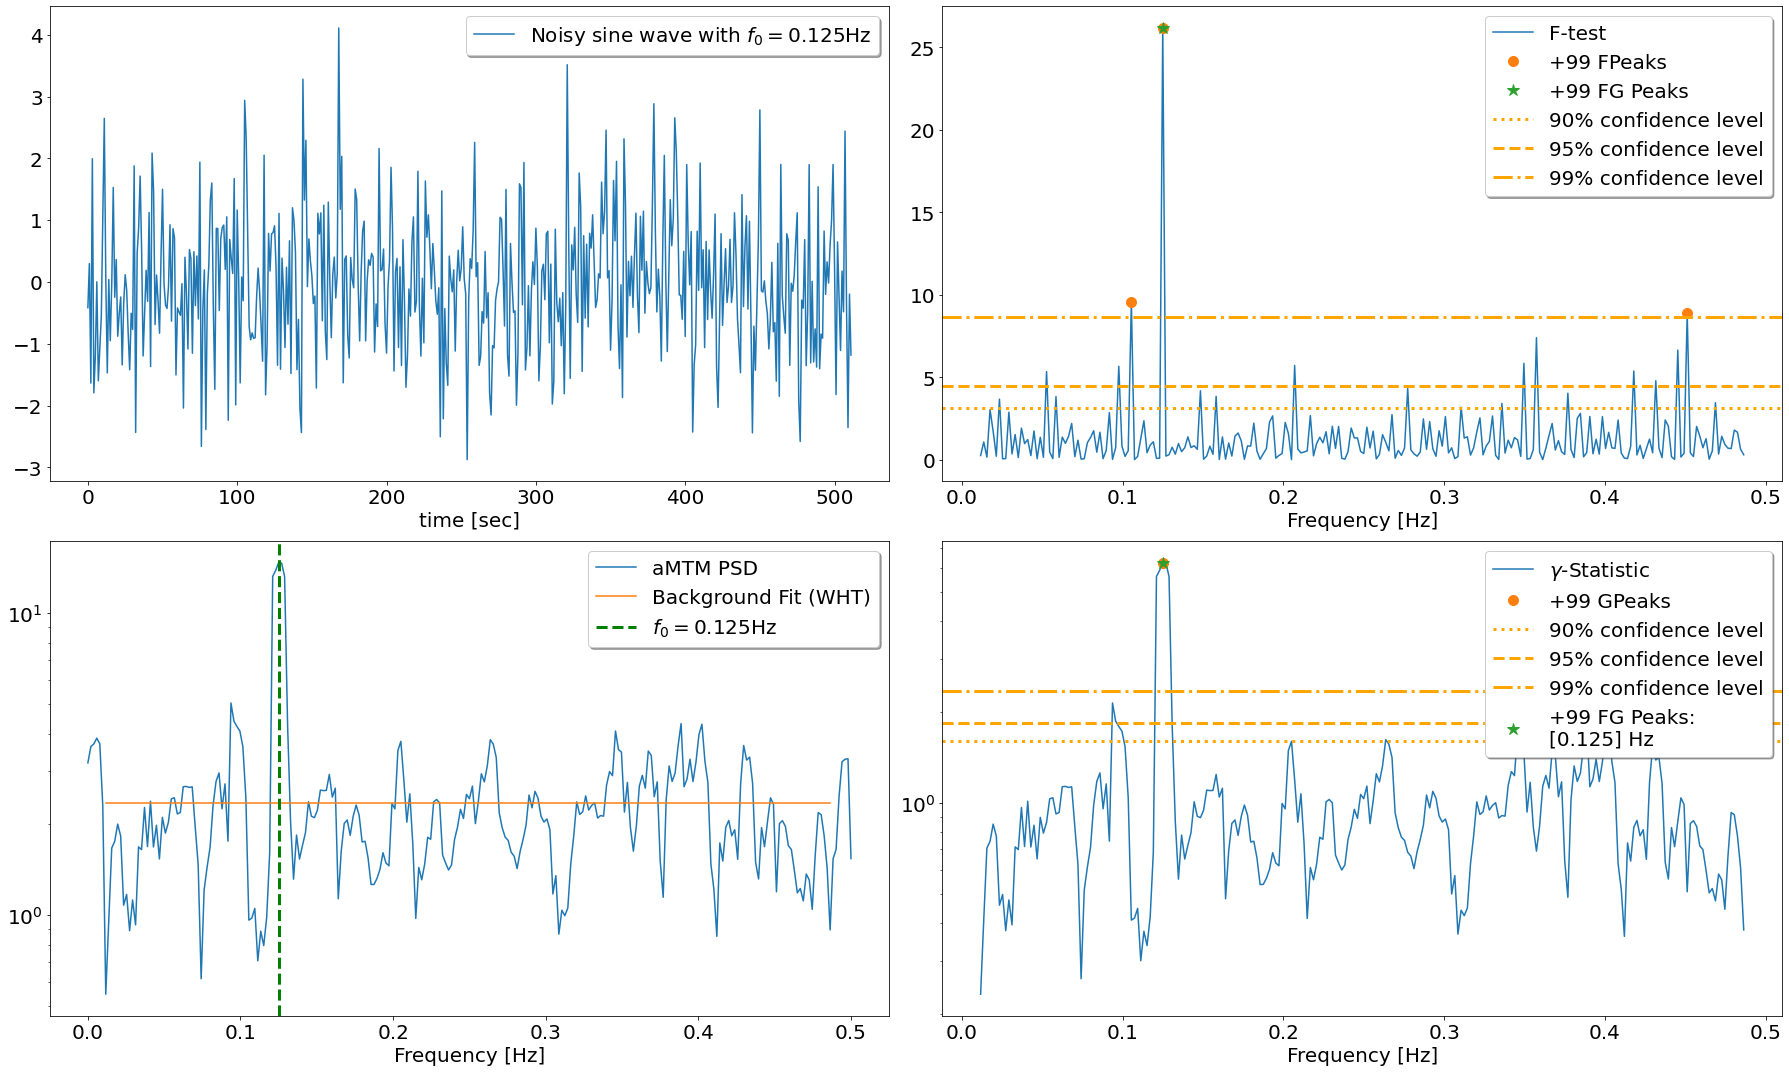

In [9]:
#import sys
#sys.path.append('/Users/salinasha/Applications/harris/idl88/lib/bridges')
#sys.path.append('/Users/salinasha/Applications/harris/idl88/bin/bin.darwin.x86_64')
#from idlpy import *
"""(7-11-2024) Having the IDL-Python bridge alters the system path such plt.savefig saves figures in the home
directory instead of the current one"""

  
def test_mtm_conf():
    """Test New SDM way of computing gamma-CDF vals using new pdf determination"""
    #Create Artificial Time Series and Plot MTM Spectra&Background
    '''
    anSeed = np.arange(1, 100,1) #create array of integers for IDL random seed numbers
    afTime = np.arange(0,512,1) #time array from 0-511seconds, dt = 1
    print('tdata length:',len(afTime))
    achFit = 'WHT'
    afX =  0.5*np.sin(2*np.pi*afTime/8) + IDL.randomn(3, 512, 1) #IDL: pure sine wave with noise(512 length, std = 1)
    freq1 = 0.125
    #-Defining time series
    '''
    afTime = np.arange(0,512,1) #time array from 0-511seconds, dt = 1
    freq1 = 1/8
    #OG_sine =  0.5*np.sin(2*np.pi*afTime/8) #IDL: pure sine wave with noise(512 length, std = 1)
    OG_sine = fSine(0.5,freq1,afTime) #pure sine wave with A = 0.5 and f = 1/8 Hz (cycles/sec)
    np.random.seed(2) #define seed so we get consistent random values
    mu, sigma = 0, 1 # standard normal distribution (Gaussian with mu = 0 and sigma = 1)
    afWhite = np.random.normal(mu, sigma, len(afTime)) #making white noise based on normal (Gaussian) distribution
    afX = OG_sine + afWhite
    #''';
    #Extract MTM Power Spectra, Freqency, and Alpha(dof) arrays for each time series
    achFit = 'WHT'
    nw_in = 3
    ktpr_in = None
    [afFk, afSk, afAlphak, afFtest] = get_amtm_specs(afX, afTime, nw_in) #NW = 3, Ktpr = 5
    [afFk_bkg, afBk, FITparams] = get_background_psdfit(afTime,afFk, afSk, afAlphak, achFit, nw_in) #Extract Spectra Background Fit
    #get_background_psdfit(afT, afFreq_mtm, afSk_mtm, afAlpha_mtm, achFIT,nw_in, frange_in) 
    
    
    #Ftest_in = trim_ftest(afTime, afFk, afFtest, nw_in, Frange = None) #have Ftest match Bkg PSD frequency range
    #Get Ftest confidence levels and frequency trimmed Ftest
    [Fcrit90, Fcrit95, Fcrit99, Ftest_in] = get_ftest_confs(2*nw_in-1, afTime, afFk, afFtest, nw_in, Frange = None)
    #Calculate confidence levels for Adaptive MTM Spectra and F-test using Simone's NEW Method
    [afGamk, Gcrit90, Gcrit95, Gcrit99, Gcrit50] = get_gamtest_confs(afTime, afFk, afSk, afAlphak, afBk, nw_in)    
    [Fpeaks, Gpeaks, FG_pk, FG_pkfreq] = get_gftest_confpeaks(afFk_bkg, afGamk, Ftest_in, Fcrit99, Gcrit99)
    #[Fpeaks95, Gpeaks95, FG_pk95, FG_pkfreq95] = get_gam_fpeaks(afFk_bkg, afGamk, afFtestk, Fcrit95, Gcrit95)
    #[Fpeaks90, Gpeaks90, FG_pk90, FG_pkfreq90] = get_gam_fpeaks(afFk_bkg, afGamk, afFtestk, Fcrit90, Gcrit90)
    #print(afGamk[55:60], '\n', afFk_bkg[55:60])
    FGpk_strings = ["%.3f" % x for x in FG_pkfreq]
    achFGfreqpks = ",".join(FGpk_strings)
    achLabFGpks = '+99 FG Peaks:\n[%s] Hz'%(achFGfreqpks)
    print(achLabFGpks)
    #----Plotting things----v
    '''
    fig, ax = plt.subplots(3, figsize = (8, 10))
    ax[0].semilogy(afFk, afSk, label = 'aMTM Spectra')
    ax[0].semilogy(afFk_bkg, afBk, label = 'Background Fit (%s)'%achFit)
    ax[0].axvline(freq1, color = 'green', ls = '--', label = r'$f_0 = %0.3f$Hz'%(freq1))
    ax[1].plot(afFk_bkg, Ftest_in, label = 'F-test')
    ax[1].plot(afFk_bkg[Fpeaks], Ftest_in[Fpeaks], 'o', ms = 6, label = '+99 FPeaks')
    ax[1].plot(afFk_bkg[FG_pk], Ftest_in[FG_pk], '*', ms = 8, label = '+99 FG Peaks')
    ax[1].axhline(y = Fcrit90,linestyle = 'dotted', color = 'orange', label = '90% confidence level')
    ax[1].axhline(y = Fcrit95,linestyle = 'dashed', color = 'orange', label = '95% confidence level')
    ax[1].axhline(y = Fcrit99,linestyle = 'dashdot', color = 'orange', label = '99% confidence level')
    ax[2].semilogy(afFk_bkg, afGamk, label = r'$\gamma$-Statistic')
    ax[2].semilogy(afFk_bkg[Gpeaks], afGamk[Gpeaks], 'o', ms = 6, label = '+99 GPeaks')
    ax[2].axhline(y = Gcrit90,linestyle = 'dotted', color = 'orange', label = '90% confidence level')
    ax[2].axhline(y = Gcrit95,linestyle = 'dashed', color = 'orange', label = '95% confidence level')
    ax[2].axhline(y = Gcrit99,linestyle = 'dashdot', color = 'orange', label = '99% confidence level')
    #ax[2].axhline(y = Gcrit50,linestyle = 'dashdot', color = 'green', label = '50% confidence level')
    ax[2].semilogy(afFk_bkg[FG_pk], afGamk[FG_pk], '*', ms = 8, label = '%s'%(achLabFGpks))
    for i in range(len(ax)):
        ax[i].legend(loc = 'upper right')
    ''';
    #-Using GridSpec to plot the various time series and corresponding FFTs
    fig = plt.figure(figsize = (25,15))
    gs = GridSpec(2, 2, figure=fig) # (Row x Col) plot
    ax1 = fig.add_subplot(gs[0, 0]) #time series
    ax2 = fig.add_subplot(gs[1, 0]) #aMTM PSD with background fit
    ax3 = fig.add_subplot(gs[0, 1]) #F-test with conf levels
    ax4 = fig.add_subplot(gs[1, 1]) #gamma-test with confidence levels
    fsize = 20 #fontsize of axis labels/ticks
    legsize = 22 #legend fontsize
    tsize = 20 #titlesize
    f_lw = 3
        #-Plotting Time Series
    ax1.plot(afTime, afX, label = r'Noisy sine wave with $f_0 = %0.3f$Hz'%(freq1))
    ax1.legend(loc = 'upper right', shadow = True, prop={'size': legsize-2})
    #ax1.set_ylabel('Amplitude Y(t)', fontsize = fsize)
    ax1.set_xlabel('time [sec]', fontsize = fsize)
        #-Plotting PSD with background fit
    ax2.semilogy(afFk, afSk, label = 'aMTM PSD')
    ax2.semilogy(afFk_bkg, afBk, label = 'Background Fit (%s)'%(achFit))#, achPSDfit))
    ax2.axvline(freq1, color = 'green', ls = '--', lw = f_lw, label = r'$f_0 = %0.3f$Hz'%(freq1))
    #ax2.set_ylabel('PSD S(f)', fontsize = fsize)
    ax2.set_xlabel('Frequency [Hz]', fontsize = fsize)
        #-Plotting F-test with conf levels
    ax3.plot(afFk_bkg, Ftest_in, label = 'F-test')
    ax3.plot(afFk_bkg[Fpeaks], Ftest_in[Fpeaks], 'o', ms = 10, label = '+99 FPeaks')
    ax3.plot(afFk_bkg[FG_pk], Ftest_in[FG_pk], '*', ms = 12, label = '+99 FG Peaks')
    ax3.axhline(y = Fcrit90,linestyle = 'dotted',lw = f_lw, color = 'orange', label = '90% confidence level')
    ax3.axhline(y = Fcrit95,linestyle = 'dashed',lw = f_lw, color = 'orange', label = '95% confidence level')
    ax3.axhline(y = Fcrit99,linestyle = 'dashdot',lw = f_lw, color = 'orange', label = '99% confidence level')
    ax3.set_xlabel('Frequency [Hz]', fontsize = fsize)
        #-Plotting Gamma-test with conf levels
    ax4.semilogy(afFk_bkg, afGamk, label = r'$\gamma$-Statistic')
    ax4.semilogy(afFk_bkg[Gpeaks], afGamk[Gpeaks], 'o', ms = 10, label = '+99 GPeaks')
    ax4.axhline(y = Gcrit90,linestyle = 'dotted',lw = f_lw, color = 'orange', label = '90% confidence level')
    ax4.axhline(y = Gcrit95,linestyle = 'dashed',lw = f_lw, color = 'orange', label = '95% confidence level')
    ax4.axhline(y = Gcrit99,linestyle = 'dashdot',lw = f_lw, color = 'orange', label = '99% confidence level')
    #ax[2].axhline(y = Gcrit50,linestyle = 'dashdot', color = 'green', label = '50% confidence level')
    ax4.semilogy(afFk_bkg[FG_pk], afGamk[FG_pk], '*', ms = 12, label = '%s'%(achLabFGpks))
    ax4.set_xlabel('Frequency [Hz]', fontsize = fsize)
        #-Legend parameters
    ax1.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
    ax2.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
    ax3.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
    ax4.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
        #-Setting tick axes labelsize
    ax1.tick_params(axis='both', labelsize=fsize)
    ax2.tick_params(axis='both', labelsize=fsize) 
    ax3.tick_params(axis='both', labelsize=fsize) 
    ax4.tick_params(axis='both', labelsize=fsize) 
    plt.tight_layout()
    fig.savefig('testdirect.png', facecolor = 'w')
    #plt.savefig('jgrTech_dualconftest_example.png', bbox_inches='tight', facecolor = 'w')
    return;
test_mtm_conf()

* (7-12-2024) writing a python package for pip install:
    * https://packaging.python.org/en/latest/tutorials/packaging-projects/
    * https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#writing-pyproject-toml
    * https://github.com/MichaelKim0407/tutorial-pip-package
    